In [1]:
%load_ext autoreload
%autoreload 2

# FiNER-139 dataset analysis

Dataset [reference](https://huggingface.co/datasets/nlpaueb/finer-139?row=0) and [paper](https://arxiv.org/abs/2203.06482).

This dataset focuses on Financial entities, as it comprises 1.1M sentences annotated with eXtensive Business Reporting Language (XBRL) tags.

- Language: English.
- Market: US.
- Sample:
    ```
    {
        'id': 40
        'tokens': ['In', 'March', '2014', ',', 'the', 'Rialto', 'segment', 'issued', 'an', 'additional', '$', '100', 'million', 'of', 'the', '7.00', '%', 'Senior', 'Notes', ',', 'at', 'a', 'price', 'of', '102.25', '%', 'of', 'their', 'face', 'value', 'in', 'a', 'private', 'placement', '.']
        'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    }
    ```


## Checking out the dataset

Let's start by checking out what we get by loading the dataset with huggingface.

In [2]:
import datasets

ds = datasets.load_dataset("nlpaueb/finer-139")
print(ds)

/home/roelschr/workspace/finer-139-task/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 900384
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 112494
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 108378
    })
})


In [3]:
tags = ds["train"].features["ner_tags"].feature.names
print(tags)

['O', 'B-AccrualForEnvironmentalLossContingencies', 'B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'I-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'B-AllocatedShareBasedCompensationExpense', 'B-AmortizationOfFinancingCosts', 'B-AmortizationOfIntangibleAssets', 'I-AmortizationOfIntangibleAssets', 'B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'I-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'B-AreaOfRealEstateProperty', 'I-AreaOfRealEstateProperty', 'B-AssetImpairmentCharges', 'B-BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued', 'B-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'I-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'B-BusinessCombinationAcquisitionRelatedCosts', 'B-BusinessCombinationConsiderationTransferred1', 'B-BusinessCombinationContingentConsiderationLiability', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssum

To clear things out, the `B-` prefix denotes the beginning of the named entity. The `I-` prefix means that this token is inside the named entity. The `O-` tag means that the corresponding word is not an entity. This means `I-` should always come with a `B-`, therefore it won't make sense to select `I-` tags without their respective `B-` tags, especially with FiNER-139. This dataset is especially complex because most of the entities are numerical values. This means that the context around the entity matters a lot more when we compare this with other NER tasks.

In [4]:
prefix_splits = {"B": set(), "I": set()}

for t in tags[1:]:
    prefix, tag = t.split("-")
    prefix_splits[prefix].add(tag)

print(prefix_splits)    

{'B': {'IncomeTaxExpenseBenefit', 'LettersOfCreditOutstandingAmount', 'DebtInstrumentConvertibleConversionPrice1', 'InterestExpenseDebt', 'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsNonvestedNumber', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 'EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate', 'DebtInstrumentUnamortizedDiscount', 'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsGrantsInPeriod', 'LeaseAndRentalExpense', 'LossContingencyPendingClaimsNumber', 'CumulativeEffectOfNewAccountingPrincipleInPeriodOfAdoption', 'SharePrice', 'CommonStockSharesOutstanding', 'ShareBasedCompensationArrangementByShareBasedPaymentAwardNumberOfSharesAvailableForGrant', 'ContractWithCustomerLiabilityRevenueRecognized', 'LineOfCreditFacilityRemainingBorrowingCapacity', 'OperatingLossCarryforwards', 'LossContingencyDamagesSoughtValue', 'AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLi

In [5]:
prefix_splits["B"].symmetric_difference(prefix_splits["I"])

set()

So, all tags can have multiple tokens. Now, let's take a quick look into `B-` tags distribution and an idea of which ones come in multiple tokens more often. For that we'll be using a sample of the train set.

In [6]:
train_sample = ds["train"].shuffle(42).select(range(ds["train"].num_rows//5))
train_sample.data

ConcatenationTable
id: int32
tokens: list<item: string>
  child 0, item: string
ner_tags: list<item: int64>
  child 0, item: int64
----
id: [[0,1,2,3,4,...,995,996,997,998,999],[1000,1001,1002,1003,1004,...,1995,1996,1997,1998,1999],...,[899000,899001,899002,899003,899004,...,899995,899996,899997,899998,899999],[900000,900001,900002,900003,900004,...,900379,900380,900381,900382,900383]]
tokens: [[["ITEM","1","Financial","Statements","Lennar",...,"in","Lennar","Multifamily","assets","."],["See","accompanying","notes","to","condensed",...,"“","Company","”",")","."],...,["In","addition",",","the","Company",...,"November","30",",","2015","."],["The","Company","’","s","financial",...,",","2015",",","respectively","."]],[["Additionally",",","at","August","31",...,"related","to","pending","litigation","."],["As","of","August","31",",",...,"to","these","site","improvements","."],...,["As","a","result",",","we",...,"be","paid","through","2019","."],["The","amounts","recorded","were","reflected"

In [7]:
counter = [0]*len(tags)
for s in train_sample:
    counted = [0]*len(tags)
    for t in s["ner_tags"]:
        if not counted[t]:
            counter[t] += 1
            counted[t] = 1


In [8]:
import pandas as pd

counter_df = pd.DataFrame({"tag": tags, "count": counter})

In [9]:
counter_df["prefix"] = counter_df["tag"].str.extract("(B-|I-)")
counter_df.head()


,tag,count,prefix
0,O,180076,NaN
1,B-AccrualForEnvironmentalLossContingencies,182,B-
2,B-AcquiredFiniteLivedIntangibleAssetsWeightedA...,259,B-
3,I-AcquiredFiniteLivedIntangibleAssetsWeightedA...,63,I-
4,B-AllocatedShareBasedCompensationExpense,763,B-


<Axes: ylabel='tag'>

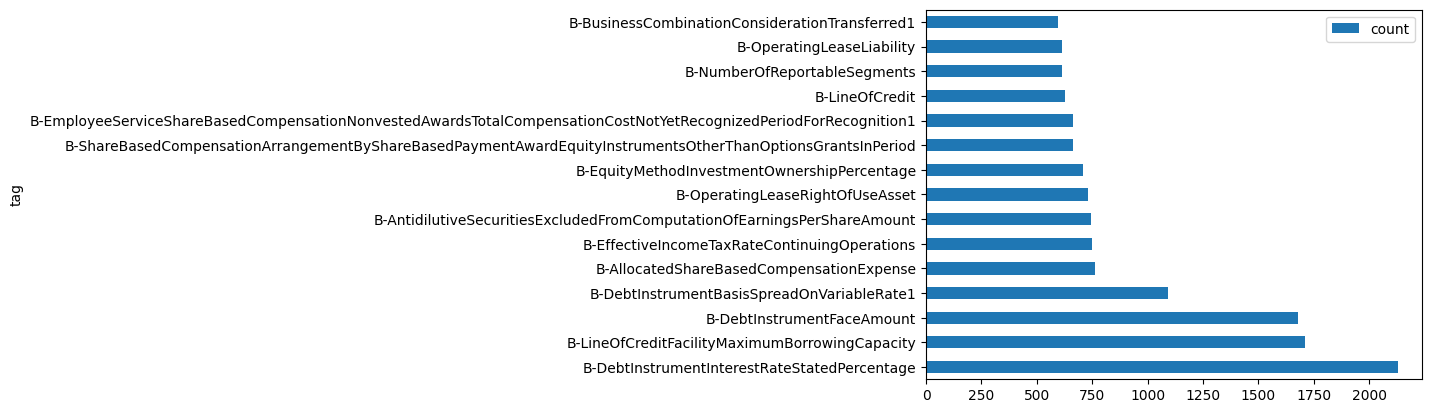

In [10]:
counter_df[counter_df["prefix"]=="B-"].sort_values(by=["count"], ascending=False)[:15].plot.barh(x="tag")

In [11]:
most_common = counter_df[counter_df["prefix"]=="B-"].sort_values(by=["count"], ascending=False)[:15].index.tolist()
most_common

[41, 87, 37, 34, 4, 57, 8, 107, 64, 140, 60, 83, 102, 105, 17]

## Selecting tags

Above we can see the most common tags (`B-` prefix) in a random 20% sample of the train set. Instead of choosing the top 4 for our training (because we have more data about them), let's instead try visualizing which ones appear together more often. 

I have limited knowledge of the matter, so I would usually ask the experts on ways that we can filter and select the most relevant tags. But given I don't have access to one right now, selecting tags that appear together more often will filter our dataset to a common topic. Tags with co-appeareance indicate similar documents and thus help us filter down the context in which the model shall operate.

In [12]:
import numpy as np
counter = np.zeros((len(tags), len(tags)))
for s in train_sample:
    filtered = list(set(s["ner_tags"]))
    if not filtered:
        continue
    for x in range(len(filtered)):
        counted = [0]*len(tags)
        counter[filtered[x], filtered[x]] += 1
        counted[filtered[x]] = 1
        for y in range(x+1, len(filtered)):
            if not counted[filtered[y]]:
                counter[filtered[x], filtered[y]] += 1
                counter[filtered[y], filtered[x]] += 1
                counted[filtered[y]] = 1

counter


array([[180076.,    182.,    259., ...,      0.,      0.,      0.],
       [   182.,    182.,      0., ...,      0.,      0.,      0.],
       [   259.,      0.,    259., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.]])

In [13]:
assert np.array_equal(counter.diagonal(), counter_df["count"].values), "Got the counter wrong"

In [14]:
for v in most_common:
    coappear = counter[v].argsort()[::-1]
    btag_coappear = counter_df.iloc[coappear][counter_df.iloc[coappear]["prefix"] == "B-"].index.values
    print(f"Tag {counter_df.loc[v]['tag']} ({counter_df.loc[v]['count']} docs) appears most commonly with tags:")
    print(dict(zip(counter_df.loc[btag_coappear[1:4]]["tag"].values, counter[v, btag_coappear[1:4]])))

Tag B-DebtInstrumentInterestRateStatedPercentage (2132 docs) appears most commonly with tags:
{'B-DebtInstrumentFaceAmount': 620.0, 'B-DebtInstrumentMaturityDate': 88.0, 'B-DebtInstrumentCarryingAmount': 71.0}
Tag B-LineOfCreditFacilityMaximumBorrowingCapacity (1711 docs) appears most commonly with tags:
{'B-DebtInstrumentFaceAmount': 88.0, 'B-LineOfCredit': 54.0, 'B-DebtInstrumentBasisSpreadOnVariableRate1': 51.0}
Tag B-DebtInstrumentFaceAmount (1681 docs) appears most commonly with tags:
{'B-DebtInstrumentInterestRateStatedPercentage': 620.0, 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 88.0, 'B-DebtInstrumentMaturityDate': 55.0}
Tag B-DebtInstrumentBasisSpreadOnVariableRate1 (1091 docs) appears most commonly with tags:
{'B-DebtInstrumentInterestRateStatedPercentage': 59.0, 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 51.0, 'B-DebtInstrumentInterestRateEffectivePercentage': 46.0}
Tag B-AllocatedShareBasedCompensationExpense (763 docs) appears most commonly with tags:
{'B-Em

As we can see, the most common tags to appear with `B-DebtInstrumentInterestRateStatedPercentage` seem similar in context:
`['B-DebtInstrumentMaturityDate' 'B-LongTermDebt' 'B-RepaymentsOfDebt']`

According to Calcbench:
- `DebtInstrumentInterestRateStatedPercentage` means "Contractual interest rate for funds borrowed, under the debt agreement."
- `DebtInstrumentMaturityDate` means "Date when the debt instrument is scheduled to be fully repaid, in YYYY-MM-DD format."
- `DebtInstrumentCarryingAmount` means "Amount, before unamortized (discount) premium and debt issuance costs, of long-term debt. Includes, but is not limited to, notes payable, bonds payable, commercial loans, mortgage loans, convertible debt, subordinated debt and other types of debt."
- `DebtInstrumentFaceAmount` means "Face (par) amount of debt instrument at time of issuance."


These tags seem to commonly appear together in financial documents as they provide a detailed overview of the terms and conditions of debt instruments.

It seems we've proved our hypothesis of filtering topics. Instead of blindly picking the most common tags, it seems more logical to go with relatively common but connected tags. This way our model will likely see documents that are similar in context and should grasp a better idea of how these tags appear due to the context. So, let's chose the most common tag and the three most "correlated" to it. In our case, we'll include `B-` and `I-` prefixes, so it's technically 8 tags.

In [15]:
v = most_common[0]
coappear = counter[v].argsort()[::-1]
btag_coappear = counter_df.iloc[coappear][counter_df.iloc[coappear]["prefix"] == "B-"].index.values
filtered_tags = counter_df.iloc[btag_coappear[:4]]
filtered_tags

,tag,count,prefix
41,B-DebtInstrumentInterestRateStatedPercentage,2132,B-
37,B-DebtInstrumentFaceAmount,1681,B-
42,B-DebtInstrumentMaturityDate,235,B-
35,B-DebtInstrumentCarryingAmount,451,B-


In [16]:
full_tags = filtered_tags["tag"].str.extract(".-(.*)")[0].values
full_tags = counter_df[counter_df["tag"].str.extract(".-(.*)")[0].isin(full_tags)]
full_tags

,tag,count,prefix
35,B-DebtInstrumentCarryingAmount,451,B-
37,B-DebtInstrumentFaceAmount,1681,B-
38,I-DebtInstrumentFaceAmount,1,I-
41,B-DebtInstrumentInterestRateStatedPercentage,2132,B-
42,B-DebtInstrumentMaturityDate,235,B-
43,I-DebtInstrumentMaturityDate,235,I-
178,I-DebtInstrumentInterestRateStatedPercentage,0,I-
185,I-DebtInstrumentCarryingAmount,0,I-


In [17]:
full_tags["tag"].to_json("../src/tags.json", indent=4)

In [18]:
%%writefile ../src/data.py
import json
import os
import random

def load_tags():
    LOCALPATH = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))

    with open(os.path.join(LOCALPATH, "tags.json")) as f:
        content = json.load(f)
        return [int(k) for k in content.keys()]

TAG_IDS = load_tags()

def retag(sample: dict) -> dict:
    """Annotates all non-selected tags as O."""
    new_tags = []
    for t in sample["ner_tags"]:
        if t not in TAG_IDS:
            new_tags.append(0)
        else:
            new_tags.append(t)
    sample["new_tags"] = new_tags
    return sample

def filter_empty(sample: dict) -> dict:
    """Returns only samples that contain at least one selected tag. Otherwise, randomly returns 1% of empty samples"""
    SEED = 42
    contains_tag = sum(sample["new_tags"]) > 0
    random.seed(SEED)
    return contains_tag or random.randint(1, 100) == SEED


Overwriting ../src/data.py


In [19]:
import os
import sys
sys.path.append("../")

from src.data import retag, filter_empty

mapped_ds = ds.map(retag, num_proc=os.cpu_count(), load_from_cache_file=False)

Map (num_proc=16): 100%|██████████| 108378/108378 [00:00<00:00, 124985.92 examples/s]


In [20]:

counter = [0]*len(tags)
for s in mapped_ds["validation"]:
    counted = [0]*len(tags)
    for t in s["new_tags"]:
        if not counted[t]:
            counter[t] += 1
            counted[t] = 1

sorted(counter)[-10:]

[0, 0, 0, 0, 153, 153, 284, 1012, 1303, 112494]

In [23]:
filtered_ds = mapped_ds.filter(filter_empty, num_proc=os.cpu_count())
filtered_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'new_tags'],
        num_rows: 18134
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'new_tags'],
        num_rows: 2252
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'new_tags'],
        num_rows: 1931
    })
})

This will leave us with only ~2% of the whole dataset, which seems ok for a fine-tuning task on a limited topic. Will of course include documents from different topics, to make sure the model sees other similar tokens that should not be annotated with one of the selected tags.